In [1]:
# Load Package
import mindspore as ms
from mindspore import Tensor
import numpy as np
import mindspore.nn as nn
from mindspore.explainer.explanation import IOX
from mindspore.explainer.explanation import CWOX

In [2]:
# Load Class_labels for ImageNet
import json
class_labels = json.load(open('resources/imagenet_class_index.json', 'r'))

In [3]:
# Load Image and Model
from mindspore.explainer.explanation._attribution._CWOX.imagenet_model.resnet50 import resnet_imagenet,read_preprocess
net=resnet_imagenet()
image_name='cello_guitar.jpg'
img_path='eval_image/'+str(image_name)
img_size = (224, 224)
image=read_preprocess(img_path,size=img_size)
inputs = Tensor(image, ms.float32)

In [4]:
# Make Prediction First
softmax = nn.Softmax()
y_hat=softmax(net(inputs)).asnumpy()[0]
top_5=np.argsort(y_hat)[::-1][:5]
for i in top_5:
    print([i,class_labels[str(i)][1],y_hat[i]])

[486, 'cello', 0.83854645]
[402, 'acoustic_guitar', 0.081863225]
[420, 'banjo', 0.035941638]
[889, 'violin', 0.020674098]
[546, 'electric_guitar', 0.0077826846]


In [6]:
# Divide the Top 5 prediction classes into Confusion Clusters using learnt HLTM
from mindspore.explainer.explanation import apply_hltm
clusterify_resnet50 = apply_hltm(cut_level=0,json_path="resources/ResNet50.json")
cluster_use_final= clusterify_resnet50.get_cluster(top_5)
print(cluster_use_final)

[[486, 889], [402, 420, 546]]


## Grad-CAM

In [14]:
from mindspore.explainer.explanation import grad_cam_cwox

IOX_cluster=IOX(grad_cam_cwox(net,layer='layer4'))
IOX_class=IOX(grad_cam_cwox(net,layer='layer3'))
sal_dict=CWOX(inputs,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=50,multiple_output=False)

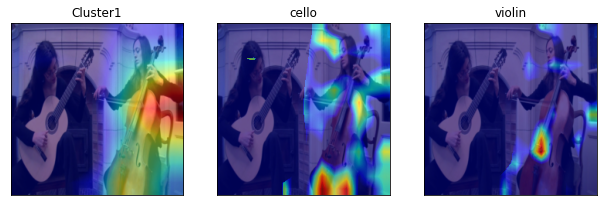

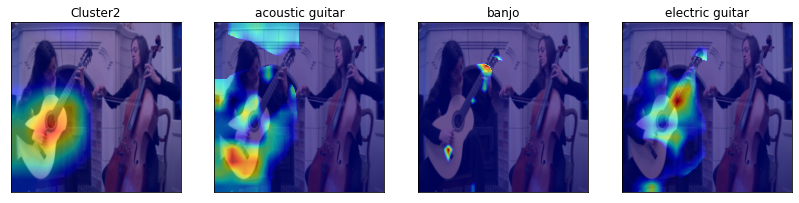

In [15]:
from mindspore.explainer.explanation import plot_cwox
plot_cwox(sal_dict,image,cluster_use_final)

## MWP

In [6]:
# Update a ResNet model to use :class:`EltwiseSum` for the skip connection.
from mindspore.explainer.explanation._attribution._backprop.excitationbackprop import update_resnet
net_update=update_resnet(net)

from mindspore.explainer.explanation import excitationbackprop_cwox
IOX_cluster=IOX(excitationbackprop_cwox(net_update,layer='layer4'))
IOX_class=IOX(excitationbackprop_cwox(net_update,layer='layer4.0.relu3'))
sal_dict=CWOX(inputs,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=60,multiple_output=False)

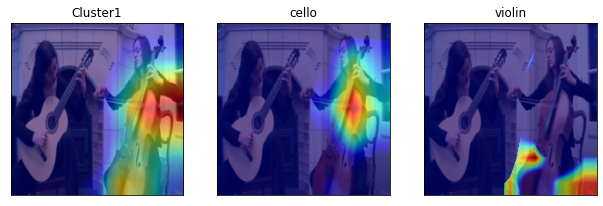

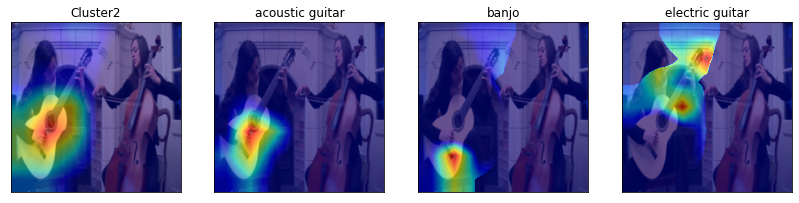

In [7]:
from mindspore.explainer.explanation import plot_cwox
plot_cwox(sal_dict,image,cluster_use_final)

## RISE

In [3]:
from mindspore.explainer.explanation import RISE_quick
from mindspore.explainer.explanation import rise_cwox

IOX_cluster=IOX(rise_cwox(net,N=5000,mask_probability=0.3,down_sample_size=15,gpu_batch=20))
IOX_class=IOX(RISE_quick(net,N=3000,mask_probability=0.14,down_sample_size=10,gpu_batch=20))
sal_dict=CWOX(inputs,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=70,multiple_output=True)

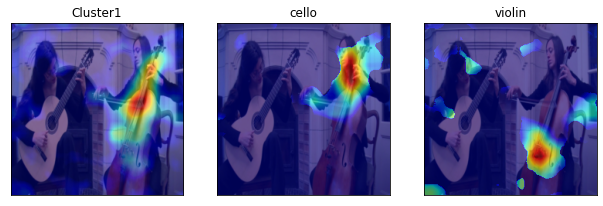

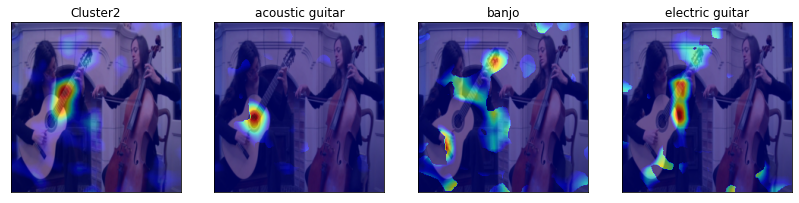

In [4]:
from mindspore.explainer.explanation import plot_cwox
plot_cwox(sal_dict,image,cluster_use_final)

## LIME

In [6]:
from mindspore.explainer.explanation import LIME
from mindspore.explainer.explanation import lime_cwox

IOX_cluster=IOX(lime_cwox(net,kernel_size=4,number_sample=2000,gpu_batch=100))
IOX_class=IOX(LIME(net,kernel_size=4,number_sample=2000,gpu_batch=100))
sal_dict=CWOX(img_path,cluster_use_final,cluster_method=IOX_cluster,class_method=IOX_class,delta=85,multiple_output=True)

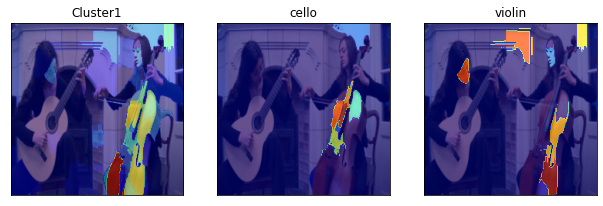

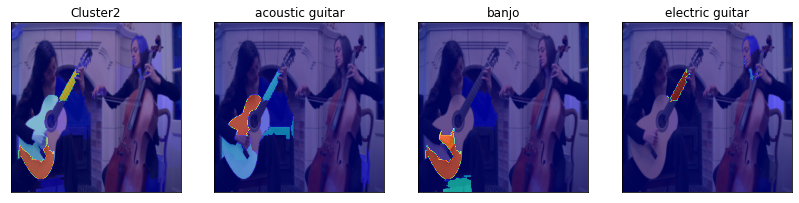

In [7]:
from mindspore.explainer.explanation import plot_cwox
plot_cwox(sal_dict,image,cluster_use_final)